# Group Meeting 9

Readings:

Hoel et al., https://www.pnas.org/content/110/49/19790

Rosas et al., https://arxiv.org/abs/2004.08220

## What is "Emergence"
"Emergence" is a core notion in modern complex systems science, although (like notions of "complexity") it has resolutely resisted attempts to pin it down. "Emergence" is generally understood to occur when the collective behavior of many interacting elements of a system produce some kind of macro-scale behavior that could not be readily predicted from knowing about the behavior of individual elements. Beyond this very "big-picture" definition, the specifics quickly become controversial, however. 

Some have argued that the idea of "emergence" conflicts with the scientific principle of reductionism (that causal power is necessarily pinned to the lowest level of a system). Others have argued for the existence of genuine "strong emergence:" emergent properties that cannot be causally related to the configuration of the individual elements. In the middle ground is "weak emergence", which proposes that causal power is *actually* pinned at the lowest level of the hierarchy, but that predictable macro-scale dynamics and meaningful and interesting. 

A strong emergentist would claim that the socio-political phenomenon of communism could not be understood or predicted just looking at atoms, while a weak emergentist would claim that it could, in theory, but in practice that would be difficult and so "communism" is a useful macro-scale object, even if it doesn't *really* have causal power.

Ultimately, much of the problem with "emergence" is that a lack of formal definition has meant that the discussion has been dominated by philosophers and aging physicists with tenure (who think they're philosophers) who often disagree on defintions, meanings, and other high-level issues. A mathematical theory of emergence (even if not perfectly satisfying in every respect) would go a long way towards turning inaccessible questions into practical ones. 

While a number of attempts have been made to use statistics and information theory to describe emergence, two recent (related) attempts stand out as the current frontier of the field. 

## Renormalization-Based Approaches to Emergence

David Krakauer (President of the Santa Fe Institute) has said that a system displays "emergent" properties IF you can find some course-graining of your system that doesn't cost any predictive power. Consider fluid dynamics: in theory, you could predict the future of a flowing fluid by modeling the interaction between all of the constituent molecules and taking into account all of the various forces at work on the molecular and atomic scales. 

You don't *need* to do that, however: when modeling fluid flows, the Navier-Stokes equation (and the field of fluid dynamics more generally) appears to do allow us to do just as good a job operating at the "macro" scale (i.e. forgetting about all the indivdiual molecules) as we could do if we brute-forced the micro-scale. The extra information required to run the micro-scale simulation is greater than the predictive power you'd get out of it. 

Dr. Erik Hoel (along with Drs. Giulio Tononi and Larissa Albantakis) proposed a mathematical framework that captures this phenomena. Given a system (typically a discrete, Boolean network for simplicity) who's updating schema is defined with some transition probability matrix, you can calculate the mutual information between the past and the future, which provides a measure of how "predictable" or "dependent" the future state is on the current present state (the effective information):

\begin{equation}
E = MI(Past ; Future)
\end{equation}

Here we will work through an example of a system where $MI(Past ; Future)$ is equal at the micro and macro scales: following Krakauer, this would be an example of a system that displayed "true" emergence. 

In [2]:
import numpy as np 
import networkx as nx 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import entropy
from scipy.linalg import eig
from copy import deepcopy 

def tpm_temporal_MI(dist, M, base=2):
    """
    Given a TPM and some input distribution, calculates the Mutual Information 
    between the present state and the future state.
    
    The input distribution can be any probability distribution (usually Hmax or the equilibrium distribution of M)
    """
    assert M.shape[0] == M.shape[1], "M must be a square matrix"
    assert len(dist) == M.shape[0], "The shape of M must be len(dist)**2"
    
    #Calculating the normalized joint disribution
    M_norm = deepcopy(M)
    for i in range(M_norm.shape[0]):
        M_norm[i] = M_norm[i] * dist[i]
    
    M_norm = M_norm / np.sum(M_norm)
    H_joint = entropy(M_norm.flatten(), base=base)
    
    #Calculating the entropy of the input distribution
    H_dist = entropy(dist, base=base)
    
    #Calculation the entropy of the future distribution
    future = np.matmul(dist, M)
    H_future = entropy(future, base=base)
    
    return H_dist + H_future - H_joint

### Micro-Scale Dynamics

Here we have a "micro-scale" system with 4 elements, each of which implements a deterministic "AND" gate. The system has an associated transition probability matrix, which we can use to calculate the mutual information between the past and the future.

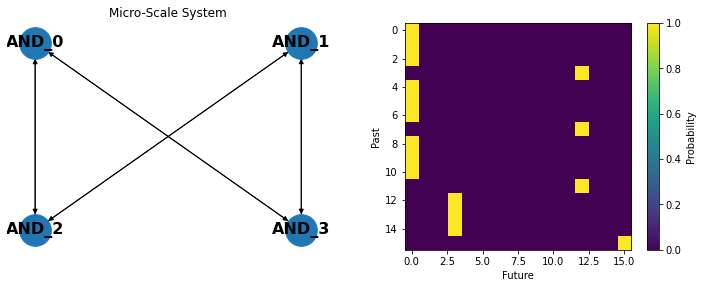

In [3]:
G = nx.DiGraph([
    ("AND_0","AND_2"),
    ("AND_0","AND_3"),
    ("AND_1","AND_2"),
    ("AND_1","AND_3"),
    ("AND_2","AND_0"),
    ("AND_2","AND_1"),
    ("AND_3","AND_0"),
    ("AND_3","AND_1")
])

pos = {
    "AND_0" : np.array([0, 1]),
    "AND_1" : np.array([1, 1]),
    "AND_2" : np.array([0, 0]),
    "AND_3" : np.array([1, 0])
 }

micro = np.zeros((2**4, 2**4))
micro[0][0] = 1
micro[1][0] = 1
micro[2][0] = 1
micro[3][12] = 1
micro[4][0] = 1
micro[5][0] = 1
micro[6][0] = 1
micro[7][12] = 1
micro[8][0] = 1
micro[9][0] = 1
micro[10][0] = 1
micro[11][12] = 1
micro[12][3] = 1
micro[13][3] = 1
micro[14][3] = 1
micro[15][15] = 1

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
nx.draw(G, pos=pos, with_labels=True, node_size=10**3, font_weight="bold", font_size=16)
plt.title("Micro-Scale System")

plt.subplot(1,2,2)
plt.imshow(micro)
plt.colorbar(label="Probability")
plt.ylabel("Past")
plt.xlabel("Future")

plt.tight_layout()

Consider what possible dynamics are possible here. If all elements are $ON$, then the system stays $ON$ forever. If it starts all $OFF$, the system stays $OFF$ forever. In fact, most starting configurations end up in the $OFF$ position forever.  

The only "interesting" configuration is one where $AND_0$ and $AND_1 = 1$ and $AND_2$ and $AND_3 = 0$. Here, the top and bottom pairs oscillate between $ON$ and $OFF$ forever. 

In [4]:
w, vl, vr = eig(micro, left=True)
eq_dist = vl[:,4] / vl[:,4].sum()
print("MI(Past ; Future):", round(tpm_temporal_MI(eq_dist, micro), 3), "Bit")

MI(Past ; Future): 1.0 Bit


In this long-term history, where the system oscilattes forever, if we can find a way to combine the $AND$ gates in such a way that perfectly preserves these dynamics, we can find a macro-scale with the same predictive information structure.

### Compressed Macro-Scale Dynamics

That compressed scale is a pair of mutually-connected $COPY$ gates. If $COPY_1 = 0$ and $COPY_1=1$, then it's clear that the pair will have the exact same dynamics as the system of $AND$ gates above. 

Text(0.5, 0, 'Future')

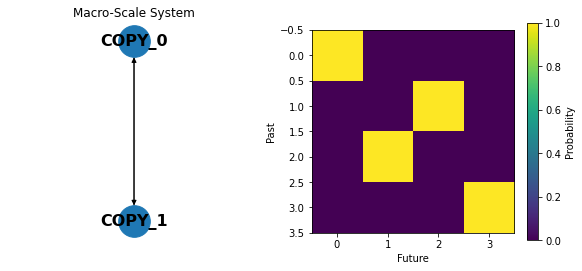

In [5]:
H = nx.DiGraph([
    ("COPY_0","COPY_1"),
    ("COPY_1","COPY_0")
])

pos = {
    "COPY_0" : np.array([0, 1]),
    "COPY_1" : np.array([0, 0])
 }

macro = np.zeros((2**2, 2**2))
macro[0][0] = 1
macro[1][2] = 1
macro[2][1] = 1
macro[3][3] = 1

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
nx.draw(H, pos=pos, with_labels=True, node_size=10**3, font_weight="bold", font_size=16)
plt.title("Macro-Scale System")

plt.subplot(1,2,2)
plt.imshow(macro)
plt.colorbar(label="Probability")
plt.ylabel("Past")
plt.xlabel("Future")

In [6]:
w, vl, vr = eig(macro, left=True)
eq_dist = vl[:,0] / vl[:,0].sum()
print("MI(Past ; Future)", tpm_temporal_MI(eq_dist, macro), "bit")

MI(Past ; Future) 1.0 bit


This satisfies Krakauer's definition: you have the same "amount" of predictive certainty at the macro-scale as you do in the micro-scale. Knowing the details of those micro-scale NAND gates doesn't buy you any extra predictive power. Here, we would say that the system of NAND gates "admits an emergent scale." 

One objection to this is that is requires choosing some particular long-term state and that throwing out the universal $OFF$ and $ON$ states is somehow "cheating."

If, instead of looking at the equilibrium distribution of the micro and macro-scale (which corresponds to simply observing the long-term behavior), we instead look at the maximum entropy distributions (which correspond to causally intervening on the state of each system), we can actually have a situation where the macro-scale has *more* predictive power than the micro-scale. 

In [7]:
print("Causal Micro MI(Past ; Future)", tpm_temporal_MI(
    np.repeat(1/micro.shape[0], micro.shape[0]), 
    micro), "Bit")

print(" ")

print("Causal Macro MI(Past ; Future)", tpm_temporal_MI(
    np.repeat(1/macro.shape[0], macro.shape[0]), 
    macro), "Bit")

Causal Micro MI(Past ; Future) 1.6225562489182659 Bit
 
Causal Macro MI(Past ; Future) 2.0 Bit


What does this mean? It means that, if you have a system and you want to *control* it (i.e. drive it towards a certain state), it will be *harder* to do that at the micro-scale than if you find a good coarse graining and intervene on the macro-scale. 

For example, consider a cell you want to kill (it could be pre-cancerous). Interveaning on the micro-scale (i.e. at the level of tweaking individual proteins or receptors) would make it very hard to drive the cell towards an apoptoptic state. There is massive degeneracy and indeterminacy in the system that makes it hard to predict exactly how tweaking a single receptor will cause long-term effects. 

In contrast, chucking the cell in an autoclave will absolutely kill it, no questions asked. 

#### Problems With this Formalism:

Two fairly major problems exist with this formalism:

1) Emergent properties / dynamics are generally *hard* to causally intervean on, since they are, almost by definition distributed and statistical in nature. For example, in people with depression, there is reliably increased statistical coupling between a few key brain regions, but that does NOT mean I can drop some kid of piece of mesh between the mPFC and the CC to "stop" the flow. 

2) The course graining requires that you *destory* information about the micro-scale distribution, leading to some unusual effects. For instance, imagine a dice, that can be in 6 states with equal probability under a maximum entropy distribution:

\begin{equation}
\{1 : 1/6, 2 : 1/6, 3 : 1/6, 4 : 1/6, 5 : 1/6, 6 : 1/6\}
\end{equation}

We could coarse grain them so everything less than 5 is a "macro-state", and 5 & 6 becomes a different macro-state. Putting this distribution under a maxent distribution is a little bit weird though:

\begin{equation}
\{[1-4] : 1/2, [5-6] : 1/2\}
\end{equation}

This is clearly weird because we *know* the micro-scale probabilities don't really work like that (the probability of getting a 1 OR 2 OR 3 OR 4 is 2/3. 

As another example, it would be like if you pulled the ace of spades from a fair deck of 52 cards and then said: "the odds I got the ace were 50/50: either I got it or I didn't." You're making a coarse graining that doesn't really following the known micro-scale distribution. 

As far as I know, Hoel et al., haven't really provided a convincing rebuttal to this second issue, although it's worth noting that IF we constrain the macro-distribution to match the maximum entropy distribution of the micro-distribution we could still satisfy Krakauer's criteria: you can have the $MI(Past;Future)$ be equal at both scales, although you can no longer find a macro that *beats* the micro.

## Synergy-Based Approaches to Emergence ($\Phi$ID)

An alternative approach was proposed by Rosas et al., recently. This involves breaking down how redundant and synergistic information is present in an evolving dynamical system, with the notion that synergy -> emergence. 

Consider a system with two elements evolving in time and both elements interact (i.e. the state of $X$ at time $t+1$ is some function of both $X$ and $Y$ at time $t$):

<ipython-input-8-92460bda7b2a>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


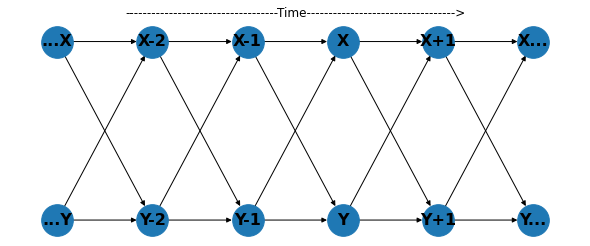

In [8]:
sys = nx.DiGraph([
    ("...X", "X-2"),
    ("...X", "Y-2"),
    ("...Y", "Y-2"),
    ("...Y", "X-2"), 
    ("X-2", "X-1"),
    ("X-2", "Y-1"),
    ("Y-2", "Y-1"),
    ("Y-2", "X-1"),  
    ("X-1", "X"),
    ("X-1", "Y"),
    ("Y-1", "Y"),
    ("Y-1", "X"),
    ("X", "X+1"),
    ("X", "Y+1"),
    ("Y", "Y+1"),
    ("Y", "X+1"),   
    ("X+1", "X..."),
    ("Y+1", "Y..."),
    ("X+1", "Y..."),
    ("Y+1", "X..."),
])

pos = {
    "...X":np.array([-1,1]),
    "...Y":np.array([-1,0]),
    "X-2":np.array([0,1]),
    "Y-2":np.array([0,0]),
    "X-1":np.array([1,1]),
    "Y-1":np.array([1,0]),
    "X":np.array([2,1]),
    "Y":np.array([2,0]),
    "X+1":np.array([3,1]),
    "Y+1":np.array([3,0]),
    "X...":np.array([4,1]),
    "Y...":np.array([4,0]),
}

plt.figure(figsize=(8,3))
nx.draw(G=sys, pos=pos, with_labels=True, node_size=10**3, font_weight="bold", font_size=16)
plt.title("-----------------------------------Time---------------------------------->")
plt.tight_layout()

If our system is Markovian (recall, memory doesn't matter, the only thing influencing the state of $X_t$ is the states of $X_{t-1}$ and $Y_{t-1}$), then, as with with the renormalization-based approach, we can look at how the past constrains the future with:

\begin{equation}
E = MI(X_{t-1}Y_{t-1} : X_tY_t)
\end{equation}

Rosas et al., provide a formalism wherein "emergence" is understood as synergistic interactions between elements of the system: i.e. if combinations of elements have "intrisic dynamics" that are irreducable or semi-indepenent from the states of their constitutent elements, you have "true" emergence. They use partial-information decomposition to dervie a "double redundancy lattice" that captures the *flow* of information from the past to the future, across all elements. 

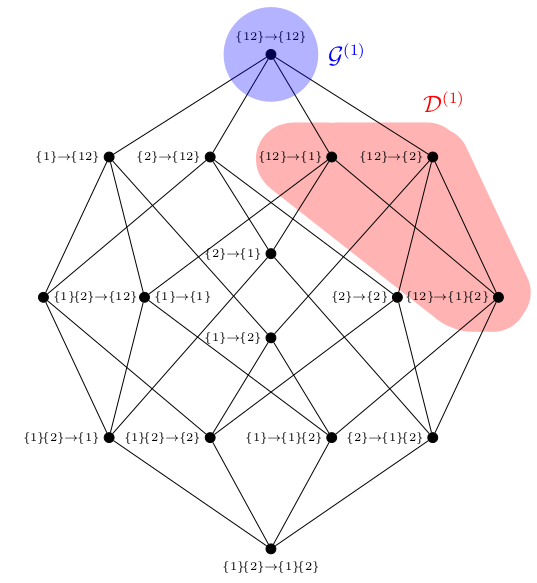

The notation here is very similar to what was introduced last time in the PID notebook. For example \{1\}\{2\} corresponds to the information redundantly present in $X_1$ and $X_2$, while \{12\} corresponds to that information synergisticall present in the joint states of $X_1$ and $X_2$ and not present in any simpler combination of sources. The arrow ($\rightarrow$) corresponds to the directed flow of time, indicating information present in one combination of elements at time $t-1$ that moves into some other combination of elements at time $t$. For example: $\{1\}\{2\}\rightarrow\{1\}\{2\}$ corresponds to that information that is redundantly present in both $X_1$ and $X_2$ and remains there as the system evolves. 

In contrast, $\{1\}\{2\}\rightarrow\{12\}$ corresponds to information that is initially redundantly present in $X_1$ and $X_2$ and then moves into the synergistic joint states of $X_1$ and $X_2$ considered together. Rosas et al., then define two sets of this time-extended atoms as defining "emergent" dynamics:

##### Causal Decoupling
Causal decoupling (the blue circle at the top of the lattice) occurs when information remains synsergistically present in the joint states of $X_1$ and $X_2$, without involving any lower-order combination of elements. Consider a simple case of a two element system where the *parity* of $ONs$ and $OFFs$ remains fixed with a 90% probability, but the specific states are randomly decided:

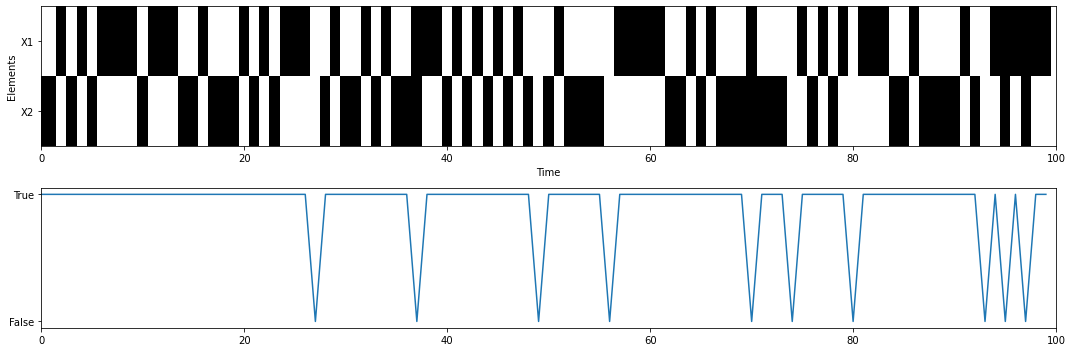

In [55]:
rand = np.random.randint(0,2,100)
pair = np.logical_not(rand)
picks = np.random.randint(0,100, 10)

sys = np.vstack((rand, pair))
sys[0,picks] = np.mod(sys[0,picks] + 1, 2)

parity = np.mod(np.sum(sys, axis=0), 2)

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.imshow(sys, cmap="gray", aspect="auto")
plt.xlabel("Time")
plt.ylabel("Elements")
plt.yticks([0,1], ["X1", "X2"])
plt.xlim([0, 100])

plt.subplot(2,1,2)
plt.plot(parity)
plt.yticks([0, 1], [False, True])
plt.xlim([0, 100])

plt.tight_layout()

Here, the mutual information between any element $X$ and it's past/future is 0, as the next states are selected randomly, however, the "emergent feature" (in this case, the parity) is (almost) always preserved. The key insight is that we could flip all of the states of both elements and the parity function would remain preserved:

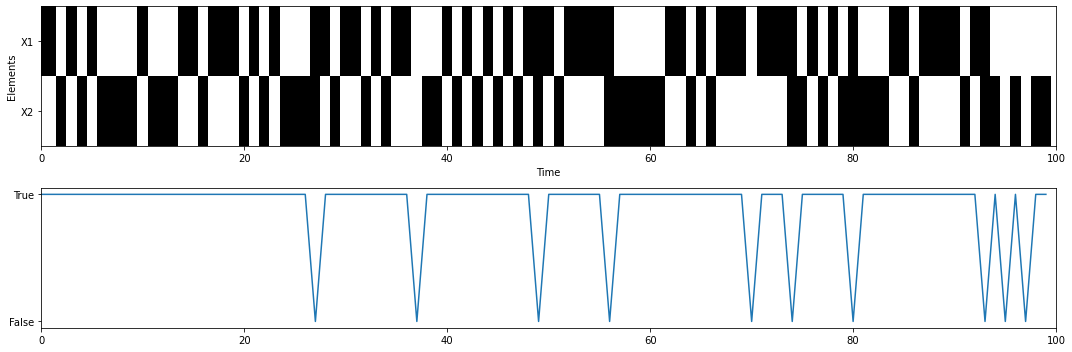

In [56]:
plt.figure(figsize=(15,5))
flip_sys = np.mod(sys+1, 2)
parity = np.mod(np.sum(sys, axis=0), 2)

plt.subplot(2,1,1)
plt.imshow(flip_sys, cmap="gray", aspect="auto")
plt.xlabel("Time")
plt.ylabel("Elements")
plt.yticks([0,1], ["X1", "X2"])
plt.xlim([0, 100])

plt.subplot(2,1,2)
plt.plot(parity)
plt.yticks([0, 1], [False, True])
plt.xlim([0, 100])

plt.tight_layout()

The parity is like the $XOR$ gate - it is only accessible from the joint states of $X_1$ and $X_2$, and the question of whether parity is preserved is only present at the top of the double redundancy lattice ($\{12\}\rightarrow\{12\}$) and no lower-order information defines it (as demonstrated by the fact that we can flip all the bits and retain the exact same parity function).

You could imagine using the parity function to encode information about some other binary variable $Z$: say:

\begin{equation}
parity(X_1(t), X_2(t)) = Z(t)
\end{equation} 

Here, knowing the invidual states of $X_1(t)$ and $X_2(t)$ is unnecessary to decode $Z$ - all you need to know is where $X_1 = X_2$ or not. 

##### Downward Causation

The other "type" of emergence that the double redundancy lattice reveals is that of "downward causation", which occures when information synergistically present in the joint state of some larger set of variables constrains the future state of a smaller set of variables (see the pink region on the double redundancy lattice) - for example $\{12\}\rightarrow\{1\}$, where the information synergistically present in $X_1$ and $X_2$ at time $t$ constrains the state of $X_1$ at time $t+1$.

Remember that synergistic information can be agnostic to the specific states of the constitutent elements (eg. $parity(X_1=1, X_2=0) = parity(X_1=0, X_2=1)$.

Downward causation is of great interest to complex systems scientists at large, for it can open the door to interesting recursive processes and feedback loops. For instance, the joint state of the temperatures in every region of the arctic ocean has a collective effect on the future temperatures in any particular region, as hotter temperatures collectively melts more ice, reducing the albedo affect, causing the temperature to rise. 

Similarly, the transition from abiotic chemistry to life seems to involve the emergence of downwards-causal processes (Pat can expand on that).

#### Problems with this formalism

1) Like all PID-based analyses, this is almost impossible to complete for anything other than toy systems. Recall that in "classical" PID, the number of atoms grows with the Dedekind number of parents - for the double redundancy lattice, the number of atoms grows with two to the power of the Dedekind number number of parents. Absolutely astronomical. 

Rosas et al., provide a few heuristics to allow reserachers to estimate the emergent dynamics in a time-series dataset, however they are limited in scope. This is definitely an area where future work is key.

2) I am not entirely convinced that "synergy" is the best, or most intuitive, understanding of "emergence". A lot of it boils down to "if a process is like an XOR gate, then it is emergent", but I'm not sure that fits with our intuition about emergence. Is an XOR gate "more" emergent, in some way, than an OR or AND gate? 

### My Recent Work

I will briefly talk about the work I'm doign with Erik Hoel attempting to bridge these two formalisms. Both of us agree that "emergence" (classically understood) really requires some notion of "coarse graining." In our mind, emergence requires some kind of coarse graining, and so we want to be able to compare the PID-breakdown of dynamical systems at macro and micro scales. 

Since the double-redundancy lattice is too large for system larger than $N=3$, we are breaking down the following mutual information term (shown for $N=2$ for simplicity sake):

\begin{equation}
MI(X_{t-1}Y_{t-1};X_tY_t) = Red(X_{t-1},Y_{t-1} ; X_tY_t) + Unq(X_{t-1} ; X_tY_t) + Unq(Y_{t-1} ; X_tY_t) + Syn(X_{t-1}Y_{t-1} ; X_tY_t)
\end{equation}

This allows us to see how information about the future *joint state* of the system is constrained by redundant and synergistic relationships between all of the elements in the past. Note that this does *not* require a double-redundancy lattice, as the "parents" are all the elements at time $t$ and the single *target* is the joint states of all elements at time $t+1$.

We can then coarse grain our system and do the same PID using the coarse-grained macro-elements. Our hypothesis (which has largely been bourne out) is that a *good* coarse graining (i.e. one that preserves the mutual information between past and future at both scales) involves moving "redundant" information *up* the PID lattice, so that more of the mutual information is localized higher up on the lattice. 

Our hope is that this will allow us to use PID to understand renormalization, giving us something like the best of both worlds. 
